## Imports

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import calendar
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from geopy.distance import geodesic
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import requests
from datetime import datetime
import geopandas as gpd

from populationOffset import popOffset

## Utils

In [6]:
def get_days_in_month(year, month):
    _, num_days = calendar.monthrange(year, month)
    return num_days

def get_day_in_year(year, month, day):
    day_in_year = 0

    for m in range(1, month):
        day_in_year += get_days_in_month(year, m)

    day_in_year += day - 1

    return day_in_year

def add_hour_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    return df
def add_day_in_year_features(df):
    # Convertir la variable 'day_in_year' a variables cícliches
    df['day_in_year_sin'] = np.sin(2 * np.pi * df['day_in_year'] / 365)
    df['day_in_year_cos'] = np.cos(2 * np.pi * df['day_in_year'] / 365)
    
    return df

def add_time_features(df):
    df = add_hour_features(df)
    
    df = add_day_in_year_features(df)
    
    return df

def acostar_a_1(x, factor=0.1):
    return x + (1 - x) * factor

def was_it_raining(rainfall_df, lat, lon, date):
    filtered = rainfall_df[
        (rainfall_df["lat"] == lat) & 
        (rainfall_df["lon"] == lon) & 
        (rainfall_df["date"] == date.strftime("%Y-%m-%d")) & 
        (rainfall_df["hour"] == date.hour)
    ]
    return filtered["rain"].iloc[0] > 0 if not filtered.empty else False
    
def fetch_rainfall_data(lat, lon, start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq="D")
    rain_data = []

    for date in dates:
        formatted_date = date.strftime("%Y-%m-%d")
        url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={formatted_date}&end_date={formatted_date}&hourly=rain"
        
        response = requests.get(url)
        data = response.json()
        
        if response.status_code == 200 and "hourly" in data:
            for i, rain in enumerate(data["hourly"]["rain"]):
                hour = i
                day_of_year = date.timetuple().tm_yday
                rain_data.append({"date": formatted_date, "hour": hour, "lat": lat, "lon": lon, "rain": rain})
        else:
            print(f"No data for {formatted_date}")

    return pd.DataFrame(rain_data)

def create_rainfall_dataset(locations, start_date="2023-01-01", end_date="2023-12-31"):
    all_rain_data = []
    for lat, lon in locations:
        print(f"Fetching rain data for location: ({lat}, {lon})")
        rain_df = fetch_rainfall_data(lat, lon, start_date, end_date)
        all_rain_data.append(rain_df)
    
    return pd.concat(all_rain_data, ignore_index=True)

## Dades

In [23]:
observations = pd.read_csv("../Data/gene_sconcno2_2023_xvpca_emep_port.csv")
stations_info = pd.read_csv("../Data/XVPCA_info_sconcno2_2023.csv")

gpd_population = gpd.read_file("../Data/poblacio/gridpoblacio01012022.shp")

In [8]:
observations_transformed = observations.melt(id_vars=["Date"], var_name="Station", value_name="concentration")

stations_info.rename(columns={"code": "Station", "lat": "Latitude", "lon": "Longitude"}, inplace=True)
observations_transformed = observations_transformed.merge(stations_info, on="Station", how="left")

observations_transformed = observations_transformed[["Date", "Latitude", "Longitude", "concentration"]]
observations_transformed.rename(columns={"Date": "date", "Latitude": "lat", "Longitude": "lon"}, inplace=True)

# Eliminar files amb valors NaN en lat, lon o concentració
observations_transformed.dropna(subset=["lat", "lon", "concentration"], inplace=True)

In [9]:
observations_transformed

,date,lat,lon,concentration
1,2023-01-01 00:00:00,41.317277,2.134501,19.50
2,2023-01-01 01:00:00,41.317277,2.134501,18.50
3,2023-01-01 02:00:00,41.317277,2.134501,18.20
4,2023-01-01 03:00:00,41.317277,2.134501,22.60
5,2023-01-01 04:00:00,41.317277,2.134501,16.60
...,...,...,...,...
560612,2023-12-30 19:00:00,41.393887,0.734722,6.55
560613,2023-12-30 20:00:00,41.393887,0.734722,5.07
560614,2023-12-30 21:00:00,41.393887,0.734722,3.59
560615,2023-12-30 22:00:00,41.393887,0.734722,3.19


In [10]:
average_concentration = observations_transformed["concentration"].mean()
average_concentration

np.float64(16.075015088271584)

In [11]:
data_transformed = observations_transformed.copy()

data_transformed['date'] = pd.to_datetime(data_transformed['date'])

data_transformed['day_in_year'] = data_transformed.apply(
    lambda row: get_day_in_year(row['date'].year, row['date'].month, row['date'].day), axis=1
)
data_transformed['hour'] = data_transformed['date'].dt.hour

data_transformed = data_transformed.drop(columns=['date'])

print("Exemple Data Transformed:")
data_transformed.iloc[9999]

Exemple Data Transformed:


lat              41.385366
lon               2.154030
concentration    27.000000
day_in_year      99.000000
hour              6.000000
Name: 11143, dtype: float64

In [12]:
data_final = add_time_features(data_transformed)

data_final = data_final.drop(columns=["day_in_year", "hour"])

print(data_final.head())

         lat       lon  concentration  hour_sin  hour_cos  day_in_year_sin  \
1  41.317277  2.134501           19.5  0.000000  1.000000              0.0   
2  41.317277  2.134501           18.5  0.258819  0.965926              0.0   
3  41.317277  2.134501           18.2  0.500000  0.866025              0.0   
4  41.317277  2.134501           22.6  0.707107  0.707107              0.0   
5  41.317277  2.134501           16.6  0.866025  0.500000              0.0   

   day_in_year_cos  
1              1.0  
2              1.0  
3              1.0  
4              1.0  
5              1.0  


In [13]:
X = data_final[['hour_sin', 'hour_cos', 'day_in_year_sin', 'day_in_year_cos']]
y = data_final['concentration']

In [14]:
y_mean = y.mean()

# Normalitzar y basat en la mitjana
y_normalized = (y - y_mean) / y_mean

# Dividir les dades en entrenament i test
X_train, X_test, y_train, y_test = train_test_split(X, y_normalized, test_size=0.2, random_state=42)

# Transformació polinòmica i regressió lineal
poly = PolynomialFeatures(degree=7, include_bias=False)
model = make_pipeline(poly, LinearRegression())

# Entrenar el model
model.fit(X_train, y_train)

# Predir valors (normalitzats)
y_pred_normalized = model.predict(X_test)

# Calcul de l'MSE
mse = mean_squared_error(y_test, y_pred_normalized)
print("MSE (normalitzat):", mse)

# Mostrar les prediccions normalitzades
print("Prediccions normalitzades (mitjana):", y_pred_normalized[:5])

# Desnormalitzar les prediccions
y_pred_original = y_pred_normalized * y_mean + y_mean
print("Prediccions desnormalitzades:", y_pred_original[:5])

MSE (normalitzat): 0.8034759307217382
Prediccions normalitzades (mitjana): [-0.24689694  0.18893815  0.42095036 -0.21974619  0.54386905]
Prediccions desnormalitzades: [12.10614305 19.11219875 22.84179845 12.54259178 24.81771826]


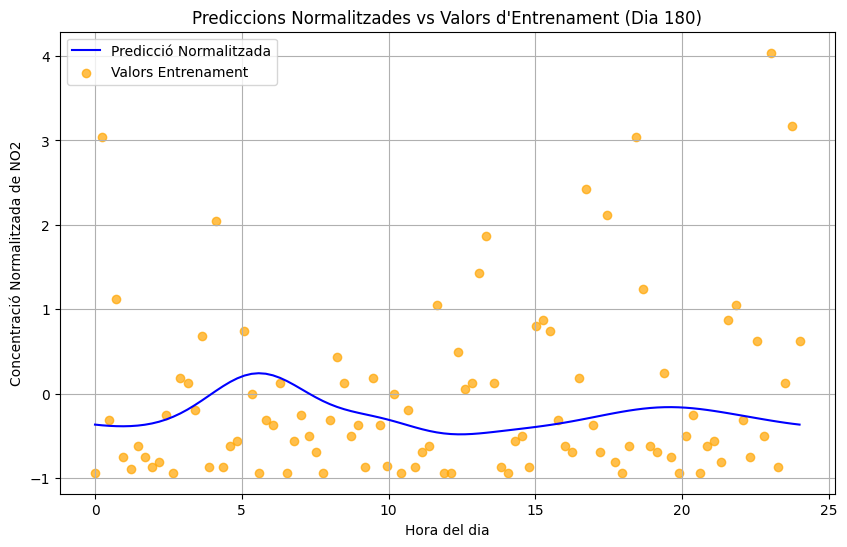

In [15]:
day_of_year = 180
hour = np.linspace(0, 24, 100)

hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)
day_sin = np.sin(2 * np.pi * day_of_year / 365)
day_cos = np.cos(2 * np.pi * day_of_year / 365)

X_day = pd.DataFrame({
    'hour_sin': hour_sin,
    'hour_cos': hour_cos,
    'day_in_year_sin': [day_sin] * len(hour),
    'day_in_year_cos': [day_cos] * len(hour),
})

y_pred_day = model.predict(X_day)
y_train_sample = y_train[:len(hour)]  # Considerem només els primers valors

# Gràfic corregit
plt.figure(figsize=(10, 6))

# Gràfic de prediccions
plt.plot(hour, y_pred_day, label='Predicció Normalitzada', color='blue')

# Gràfic de valors d'entrenament
plt.scatter(hour[:len(y_train_sample)], y_train_sample, label='Valors Entrenament', color='orange', alpha=0.7)

# Estil del gràfic
plt.title(f"Prediccions Normalitzades vs Valors d'Entrenament (Dia {day_of_year})")
plt.xlabel("Hora del dia")
plt.ylabel("Concentració Normalitzada de NO2")
plt.legend()
plt.grid()
plt.show()


In [16]:
def filter_by_radius(data_transformed, center_lat, center_lon, radius_km, k):
    # Obtenir les coordenades úniques
    unique_coords = data_transformed[['lat', 'lon']].drop_duplicates()
    
    # Calcular les distàncies per a cada coordenada única
    unique_coords['distance'] = unique_coords.apply(
        lambda row: geodesic((center_lat, center_lon), (row['lat'], row['lon'])).km, axis=1
    )
    
    # Filtrar les coordenades úniques dins del radi
    within_radius = unique_coords[unique_coords['distance'] <= radius_km]
    
    # Seleccionar les k coordenades més properes
    top_k_coords = within_radius.nsmallest(k, 'distance')
    
    # Fer un merge amb el dataframe original per filtrar les files corresponents
    result_df = data_transformed.merge(top_k_coords[['lat', 'lon']], on=['lat', 'lon'])
    
    return result_df

In [17]:
locations = [(41.39216, 2.009802), (41.11588, 1.191975), (41.44398, 2.237875), (41.32177, 2.082141)]

radius = 3

datasets_near = []
for lat, lon in locations:
    print((lat, lon))
    observations_near = filter_by_radius(data_transformed, lat, lon, radius,6)
    datasets_near.append((lat, lon, observations_near))

(41.39216, 2.009802)
(41.11588, 1.191975)
(41.44398, 2.237875)
(41.32177, 2.082141)


In [18]:
datasets_near[0]

(41.39216,
 2.009802,
             lat       lon  concentration  day_in_year  hour  hour_sin  \
 0     41.400771  1.999635           29.0          364    23 -0.258819   
 1     41.400771  1.999635           34.0            0     0  0.000000   
 2     41.400771  1.999635           35.0            0     1  0.258819   
 3     41.400771  1.999635           33.0            0     2  0.500000   
 4     41.400771  1.999635           29.0            0     3  0.707107   
 ...         ...       ...            ...          ...   ...       ...   
 8573  41.400771  1.999635           31.0          364    18 -1.000000   
 8574  41.400771  1.999635           37.0          364    19 -0.965926   
 8575  41.400771  1.999635           24.0          364    20 -0.866025   
 8576  41.400771  1.999635           39.0          364    21 -0.707107   
 8577  41.400771  1.999635           21.0          364    22 -0.500000   
 
           hour_cos  day_in_year_sin  day_in_year_cos  
 0     9.659258e-01        -0.01

In [19]:
models = []

for lat, lon, dataset_near in datasets_near:
    X = dataset_near[['hour_sin', 'hour_cos', 'day_in_year_sin', 'day_in_year_cos']]
    y = dataset_near['concentration']
    
    y_mean = y.mean()
    y_normalized = (y - y_mean) / y_mean
    
    poly = PolynomialFeatures(degree=10, include_bias=True)
    model = make_pipeline(poly, LinearRegression())
    
    model.fit(X, y_normalized)
    models.append((lat, lon, model, y_mean))

In [20]:
rainfall_df = create_rainfall_dataset(locations)
rainfall_df

Fetching rain data for location: (41.39216, 2.009802)
Fetching rain data for location: (41.11588, 1.191975)
Fetching rain data for location: (41.44398, 2.237875)
Fetching rain data for location: (41.32177, 2.082141)


,date,hour,lat,lon,rain
0,2023-01-01,0,41.39216,2.009802,0.0
1,2023-01-01,1,41.39216,2.009802,0.0
2,2023-01-01,2,41.39216,2.009802,0.0
3,2023-01-01,3,41.39216,2.009802,0.0
4,2023-01-01,4,41.39216,2.009802,0.0
...,...,...,...,...,...
35035,2023-12-31,19,41.32177,2.082141,0.0
35036,2023-12-31,20,41.32177,2.082141,0.0
35037,2023-12-31,21,41.32177,2.082141,0.0
35038,2023-12-31,22,41.32177,2.082141,0.0


In [21]:
rainfall_df['rain'].min()

np.float64(0.0)

In [45]:
coeficientes = [1, 1, 1, 1]

In [43]:
dates = pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")

data = []
id_counter = 1
index = 0

# Iterem per cada dataset de les zones properes
for lat, lon, dataset_near in datasets_near:
    print(f"Processing predictions for location: ({lat}, {lon})")

    # Obtener el modelo correspondiente
    model_info = next((m for m in models if m[0] == lat and m[1] == lon), None)
    if model_info is None:
        raise ValueError(f"No se encontró un modelo para la ubicación ({lat}, {lon})")
    
    model, y_mean = model_info[2], model_info[3]
    
    # Calcular la concentración media
    avg_concentration = dataset_near["concentration"].mean()
    
    for date in dates:
        # Características cíclicas
        hour = date.hour
        day_of_year = date.timetuple().tm_yday
        
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        day_sin = np.sin(2 * np.pi * day_of_year / 365)
        day_cos = np.cos(2 * np.pi * day_of_year / 365)
        
        # Crear el DataFrame para predecir
        X_single = pd.DataFrame({
            'hour_sin': [hour_sin],
            'hour_cos': [hour_cos],
            'day_in_year_sin': [day_sin],
            'day_in_year_cos': [day_cos],
        })
        
        # Predecir el coeficiente
        time_coeficient = model.predict(X_single)[0]

        rain_coeficient = 1
        if was_it_raining:
            rain_coeficient = 0.95
        
        data.append({
            "id": id_counter,
            "date": date.strftime("%Y-%m-%d %H:%M"),
            "lat": lat, 
            "lon": lon, 
            "concentration": (avg_concentration + (time_coeficient * avg_concentration))*rain_coeficient*coeficientes[index]
        })
        id_counter += 1
    index +=1

# Crear el DataFrame final
output_df = pd.DataFrame(data)

# Guardar en un arxiu CSV
output_csv_path = "output_concentration.csv"
output_df.to_csv(output_csv_path, index=False)

print(f"Arxiu generat: {output_csv_path}")

C:\Users\p2004\AppData\Local\Temp\ipykernel_17424\4195520477.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")


Processing predictions for location: (41.39216, 2.009802)
Processing predictions for location: (41.11588, 1.191975)
Processing predictions for location: (41.44398, 2.237875)
Processing predictions for location: (41.32177, 2.082141)
Arxiu generat: output_concentration.csv


In [44]:
#pd.set_option('display.max_rows', 100)
#output_df.head(100)
output_df


,id,date,lat,lon,concentration
0,1,2023-01-01 00:00,41.39216,2.009802,34.758755
1,2,2023-01-01 01:00,41.39216,2.009802,33.358344
2,3,2023-01-01 02:00,41.39216,2.009802,31.145156
3,4,2023-01-01 03:00,41.39216,2.009802,29.626577
4,5,2023-01-01 04:00,41.39216,2.009802,31.600288
...,...,...,...,...,...
35035,35036,2023-12-31 19:00,41.32177,2.082141,64.573399
35036,35037,2023-12-31 20:00,41.32177,2.082141,62.144079
35037,35038,2023-12-31 21:00,41.32177,2.082141,56.427006
35038,35039,2023-12-31 22:00,41.32177,2.082141,50.498399
